# Credit Card Kaggle Anomaly Detection

## Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Content
The dataset contains transactions made by credit cards in **September 2013** by European cardholders. This dataset presents transactions that occurred over **two days**, where we have **492 frauds** out of **284,807 transactions**. 

The dataset is highly unbalanced, as the positive class (frauds) accounts for only **0.172%** of all transactions.

### Key Details:
- The dataset contains only **numerical input variables**, which are the result of a **PCA transformation**.
- Due to confidentiality issues, the original features and more background information about the data are unavailable.
- **Features**:
  - **V1, V2, ..., V28**: Principal components obtained via PCA.
  - **Time**: Seconds elapsed between each transaction and the first transaction in the dataset.
  - **Amount**: Transaction amount, which can be used for cost-sensitive learning.
  - **Class**: Response variable (1 = Fraud, 0 = Normal).

## Inspiration
The goal is to identify fraudulent credit card transactions.

### Evaluation Metric:
Given the class imbalance ratio, it is recommended to measure accuracy using the **Area Under the Precision-Recall Curve (AUPRC)**. Confusion matrix accuracy is not meaningful for unbalanced classification.

## Acknowledgements
The dataset has been collected and analyzed during a research collaboration between **Worldline** and the **Machine Learning Group (http://mlg.ulb.ac.be)** of **ULB (Université Libre de Bruxelles)** on big data mining and fraud detection. 

More details on current and past projects on related topics are available:
- [ResearchGate: Fraud Detection Project](https://www.researchgate.net/project/Fraud-detection-5)
- [DefeatFraud Project Page](https://www.researchgate.net/project/Fraud-detection-5)


In [2]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [4]:
data = pd.read_csv('creditcard.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## Exploratory Data Analysis

In [8]:
data.isnull().values.any()

False

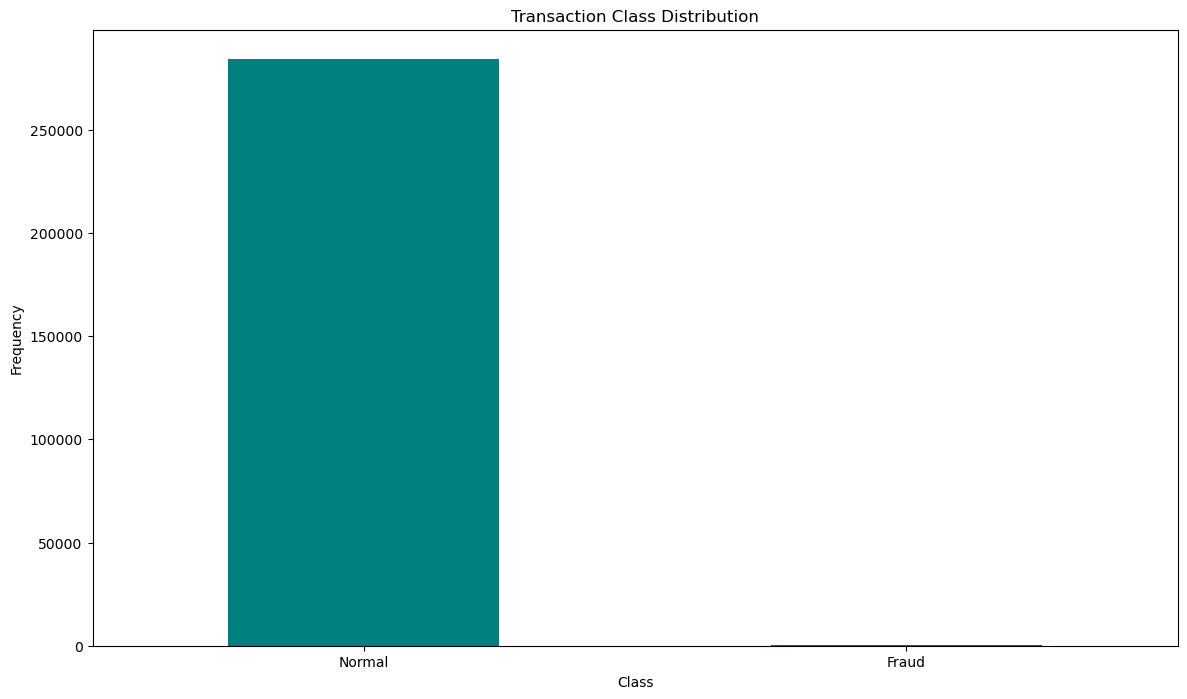

In [30]:
count_classes = data['Class'].value_counts(sort=True)

# Define colors for the bars (e.g., blue for normal and red for fraud)
colors = ['teal', 'red']  # Adjust order based on your LABELS if necessary

# Plotting the class distribution with custom colors
count_classes.plot(kind='bar', rot=0, color=colors)

plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [32]:
## Get the Fraud and the normal dataset 

fraud = data[data['Class']==1]

normal = data[data['Class']==0]

In [34]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


In [36]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [38]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [ ]:
# Plot: Amount per transaction by class
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
f.suptitle('Amount per Transaction by Class')

bins = 50
# Fraud histogram
ax1.hist(fraud['Amount'], bins=bins, color='salmon', alpha=0.7)
ax1.set_title('Fraud')

# Normal histogram
ax2.hist(normal['Amount'], bins=bins, color='teal', alpha=0.7)
ax2.set_title('Normal')

# Shared labels
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))  # Ensure consistent x-axis limits
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

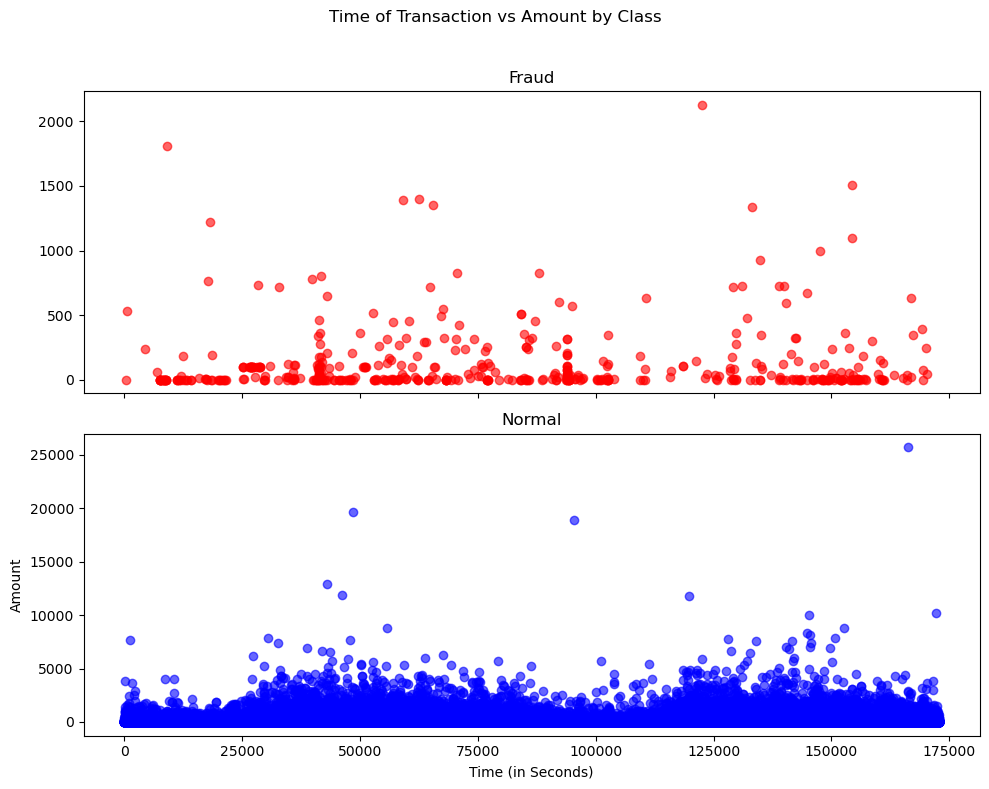

In [48]:
# Plot: Time of transaction vs Amount by class
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
f.suptitle('Time of Transaction vs Amount by Class')

# Scatter plot for fraud transactions
ax1.scatter(fraud['Time'], fraud['Amount'], color='red', alpha=0.6)
ax1.set_title('Fraud')

# Scatter plot for normal transactions
ax2.scatter(normal['Time'], normal['Amount'], color='blue', alpha=0.6)
ax2.set_title('Normal')

# Shared labels
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [17]:
## Take some sample of the data

data1= data.sample(frac = 0.1,random_state=1)

data1.shape

(28481, 31)

In [18]:
data.shape

(284807, 31)

In [19]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data1[data1['Class']==1]

Valid = data1[data1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [50]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data[data['Class']==1]

Valid = data[data['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [52]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0017304750013189597
Fraud Cases : 492
Valid Cases : 284315


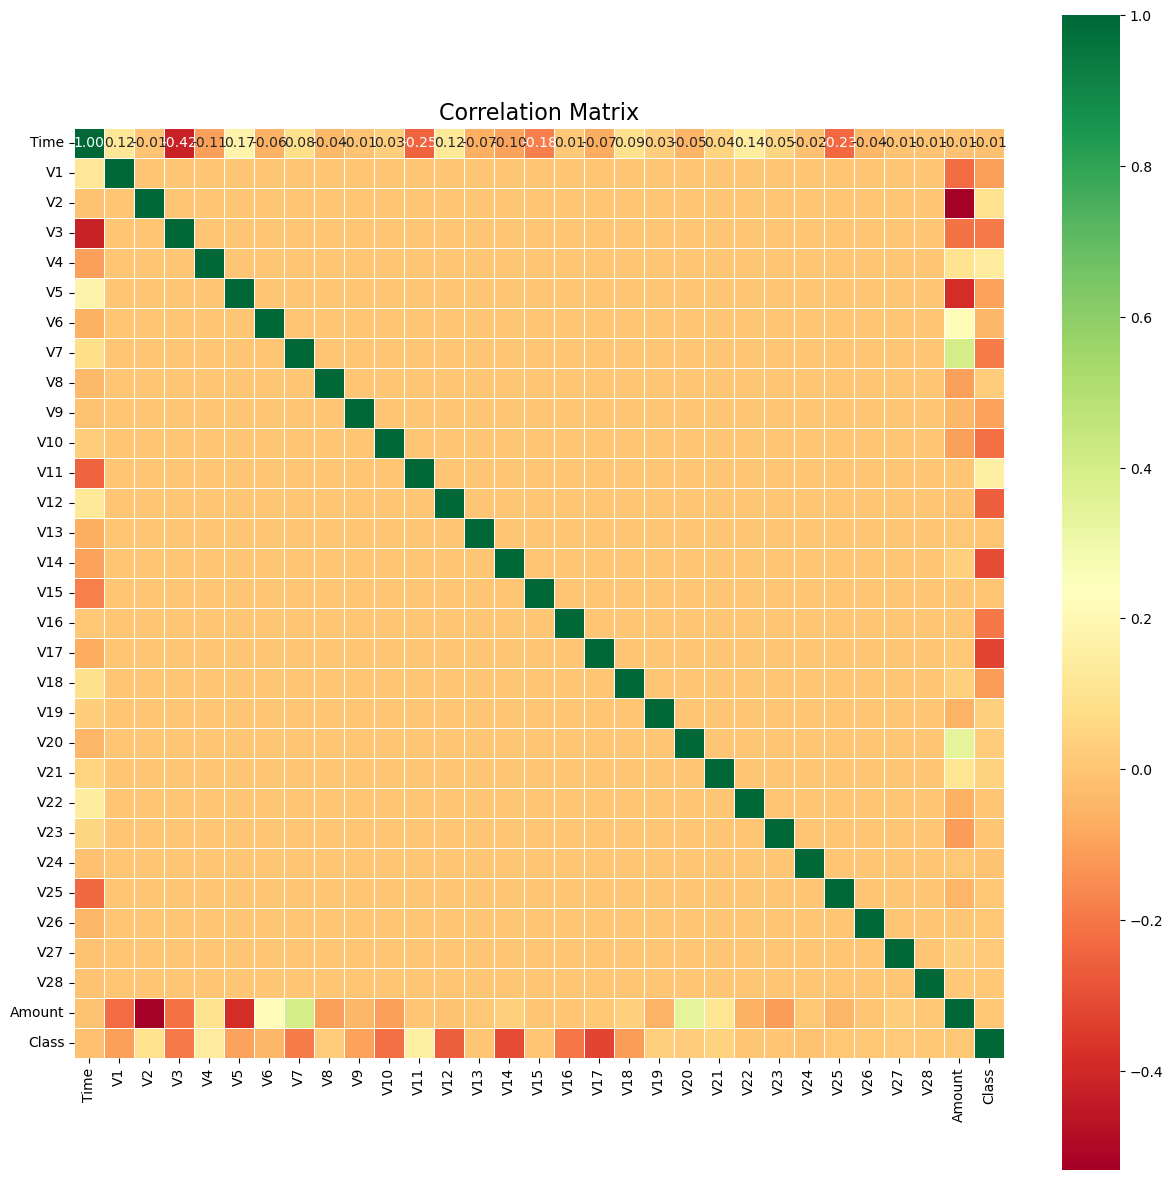

In [56]:
plt.figure(figsize=(15, 15))  # Adjust the figure size
sns.heatmap(
    corrmat,
    annot=True,              # Add correlation values
    cmap="RdYlGn",           # Use a diverging colormap
    fmt=".2f",               # Format the annotations to 2 decimal places
    square=True,             # Ensure cells are square-shaped
    linewidths=0.5           # Add gridlines between cells
)
plt.title("Correlation Matrix", fontsize=16)
plt.show()

In [58]:
#Create independent and Dependent Features
columns = data.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(284807, 30)
(284807,)


# Model Prediction

Now it's time to start building the model. The types of algorithms we are going to use to perform anomaly detection on this dataset are as follows:

## Isolation Forest Algorithm

One of the newest techniques for detecting anomalies is called **Isolation Forests**. The algorithm is based on the fact that anomalies are data points that are few and different. Due to these properties, anomalies are susceptible to a mechanism called **isolation**.

This method is highly useful and fundamentally different from existing anomaly detection methods. It introduces the use of isolation as a more effective and efficient means of detecting anomalies than the commonly used distance and density-based measures. Moreover, this method has **low linear time complexity** and **small memory requirements**, which makes it highly scalable. It can build a high-performing model with a small number of trees using small sub-samples of fixed size, regardless of the dataset's size.

### How Isolation Forests Work
The **Isolation Forest** algorithm isolates observations by:
1. Randomly selecting a feature.
2. Randomly selecting a split value between the maximum and minimum values of the selected feature.

The key idea is that **isolating anomaly observations is easier** because only a few conditions are needed to separate them from normal observations. In contrast, isolating normal observations requires more conditions. Therefore, an **anomaly score** is calculated based on the number of conditions needed to isolate a given observation.

The algorithm constructs the separation by first creating **isolation trees** (random decision trees). The score is then calculated based on the path length required to isolate the observation.

---

## Local Outlier Factor (LOF) Algorithm

The **LOF (Local Outlier Factor)** algorithm is an unsupervised outlier detection method that computes the **local density deviation** of a given data point with respect to its neighbors. It considers as outliers those samples that have a substantially lower density than their neighbors.

The number of neighbors considered (`n_neighbors` parameter) is typically chosen such that:
1. It is greater than the minimum number of objects a cluster must contain, so other objects can be local outliers relative to this cluster.
2. It is smaller than the maximum number of nearby objects that could potentially be local outliers.

In practice, such information is often not available, and a common choice is `n_neighbors = 20`, which generally works well in most cases.

n.


### Local Outlier Factor(LOF) Algorithm
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [62]:
## Define the outlier detection methods
classifiers = {
    "Isolation Forest": IsolationForest(
        n_estimators=100, 
        max_samples=len(X), 
        contamination=outlier_fraction, 
        random_state=state, 
        verbose=0
    ),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20, 
        algorithm='auto', 
        leaf_size=30, 
        metric='minkowski', 
        p=2, 
        metric_params=None, 
        contamination=outlier_fraction
    ),
    "Support Vector Machine": OneClassSVM(
        kernel='rbf', 
        degree=3, 
        gamma=0.1, 
        nu=0.05, 
        max_iter=-1
    )
}

In [66]:
type(classifiers)

dict

In [ ]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics 
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

C:\Users\sayed\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest: 675
Accuracy Score :
0.9976299739823811
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.31      0.32      0.31       492

    accuracy                           1.00    284807
   macro avg       0.66      0.66      0.66    284807
weighted avg       1.00      1.00      1.00    284807

Local Outlier Factor: 935
Accuracy Score :
0.9967170750718908
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.05      0.05      0.05       492

    accuracy                           1.00    284807
   macro avg       0.52      0.52      0.52    284807
weighted avg       1.00      1.00      1.00    284807



#### Observations :
- Isolation Forest detected 73 errors versus Local Outlier Factor detecting 97 errors vs. SVM detecting 8516 errors
- Isolation Forest has a 99.74% more accurate than LOF of 99.65% and SVM of 70.09
- When comparing error precision & recall for 3 models , the Isolation Forest performed much better than the LOF as we can see that the detection of fraud cases is around 27 % versus LOF detection rate of just 2 % and SVM of 0%.
- So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.
- We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases